# ЧТО ТАКОЕ ПАРКЕТ?

 это бинарный, колоночной-ориентированный формат хранения данных, изначально созданный для экосистемы hadoop. Разработчики уверяют, что данный формат хранения идеален для big data (неизменяемых).
parquet ведёт себя как неизменяемая таблица или БД. Значит для колонок определён тип, и если вдруг у вас комбинируется сложный тип данных (скажем, вложенный json) с простым (обычное строковое значение), то вся система разрушится.  

Паркет построен с нуля со сложными вложенными структурами данных и использует алгоритм измельчения и сборки регистров.

Паркет предназначен для поддержки очень эффективных схем сжатия и кодирования. Несколько проектов продемонстрировали влияние на производительность применения правильной схемы сжатия и кодирования к данным. Паркет позволяет указывать схемы сжатия на уровне каждого столбца и готов к будущему, чтобы добавить больше кодировок по мере их изобретения и реализации.

# Как выглядит структура Parquet файлов

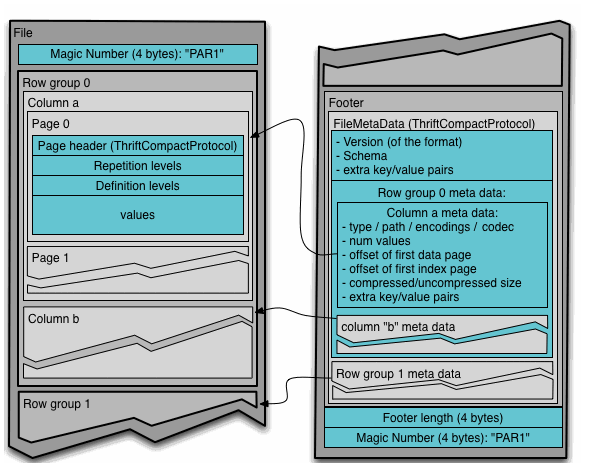

Таким образом, читатели должны сначала прочитать метаданные файла, чтобы найти все фрагменты столбцов, которые их интересуют. Затем фрагменты столбцов должны быть прочитаны последовательно.

Файлы имеют несколько уровней разбиения на части, благодаря чему возможно довольно эффективное параллельное исполнение операций поверх них:


**Row-group** — это разбиение, позволяющее параллельно работать с данными на уровне Map-Reduce.

**Page** — Разбиение колонок на страницы, позволяющее распределять работу по кодированию и сжатию

**Column chunk** — разбиение на уровне колонок, позволяющее распределять IO операции. Oптимизирует работу с диском (дисками). Если представить данные как таблицу, то они записываются не построчно, а по колонкам.

**Представим таблицу:**

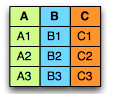

Тогда в текстовом файле, скажем, csv мы бы хранили данные на диске примерно так:

image.png

В случае с Parquet:

image.png

# КАК РАБОТАЕТ ПАРКЕТ?

In [ ]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

**Чтение и запись отдельных файлов**

Функции read_table()и write_table() читают и записывают объект pyarrow.Table

In [ ]:
df = pd.DataFrame({'one': [-1, np.nan, 2.5],
                   'two': ['foo', 'bar', 'baz'],
                   'three': [True, False, True]},
                   index=list('abc'))
table = pa.Table.from_pandas(df)

Мы записываем это в формат Parquet с помощью write_table

In [ ]:
pq.write_table(table, 'example.parquet')

Это создает один файл Parquet. На практике набор данных Parquet может состоять из множества файлов во многих каталогах. Мы можем прочитать один файл обратно с помощью read_table:

In [ ]:
table2 = pq.read_table('example.parquet')
table2.to_pandas()

,one,two,three
a,-1.0,foo,True
b,NaN,bar,False
c,2.5,baz,True


Вы можете передать подмножество столбцов для чтения, что может быть намного быстрее, чем чтение всего файла (из-за столбцового макета):

In [ ]:
pq.read_table('example.parquet', columns=['one', 'three'])

pyarrow.Table
one: double
three: bool
----
one: [[-1,null,2.5]]
three: [[true,false,true]]

**Детальное чтение и письмо**

read_table использует ParquetFileк ласс, который имеет другие особенности:

In [ ]:
parquet_file = pq.ParquetFile('example.parquet')

parquet_file.metadata

  created_by: parquet-cpp-arrow version 6.0.1
  num_columns: 4
  num_rows: 3
  num_row_groups: 1
  format_version: 1.0
  serialized_size: 2574

In [ ]:
parquet_file.schema

required group field_id=-1 schema {
  optional double field_id=-1 one;
  optional binary field_id=-1 two (String);
  optional boolean field_id=-1 three;
  optional binary field_id=-1 __index_level_0__ (String);
}

**Сжатие, кодирование и совместимость файлов**

Наиболее часто используемые реализации Parquet используют кодировку словаря при записи файлов; если словари становятся слишком большими, они «возвращаются» к простому кодированию. Использование словарной кодировки можно переключать с помощью use_dictionaryопции:

In [ ]:
pq.write_table(table, use_dictionary=False)

Страницы данных в столбце в группе строк могут быть сжаты после прохождения кодирования (словарь, кодирование RLE). В PyArrow по умолчанию используется сжатие Snappy, но также поддерживаются Brotli, Gzip и несжатое:

In [ ]:
pq.write_table(table,  compression='snappy')
pq.write_table(table,  compression='gzip')
pq.write_table(table, compression='brotli')
pq.write_table(table,  compression='none')

# Достоинства хранения данных в Parquet:



*   По сути это просто файлы, а значит с ними легко работать, перемещать, бэкапить и реплицировать.
*   Колончатый вид позволяет значительно ускорить работу аналитика, если ему не нужны все колонки сразу.
*   Эффективное хранение с точки зрения занимаемого места.






# Недостатки:



*   Колончатый вид заставляет задумываться о схеме и типах данных.
*   Не поддерживает изменение данных и эволюцию схемы. 
*   Конечно, Spark умеет мерджить схему, если у вас она меняется со временем (для этого надо указать специальную опцию при чтении), но, чтобы что-то изменить в уже существующим файле, нельзя обойтись без перезаписи, разве что можно добавить новую колонку.
*  Не поддерживаются транзакции, так как это обычные файлы а не БД.

